In [2]:
# Import dependencies
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set plotting style
sns.set_style('white')

In [3]:
# Create data paths with respective labels
def define_paths(image_dir):
    filepaths = []
    labels = []

    folds = os.listdir(image_dir)
    for fold in folds:
        foldpath = os.path.join(image_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            if fold == '1':
                labels.append('Meningioma')
            elif fold == '2':
                labels.append('Glioma')
            elif fold == '3':
                labels.append('Pituitary Tumor')

    return filepaths, labels


# Concatenate data paths with respective labels to one dataframe
def define_df(files, classes):
    file_ser = pd.Series(files, name='filepaths')
    label_ser = pd.Series(classes, name='labels')
    return pd.concat([file_ser, label_ser], axis=1)


# Split dataframe into to train, valid, and test dataframe
def create_df(image_dir):
    # Create train dataframe
    files, classes = define_paths(image_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, temp_df = train_test_split(df,  train_size=0.8, shuffle=True, random_state=123, stratify=strat)

    # Create valid and test dataframe
    strat = temp_df['labels']
    valid_df, test_df = train_test_split(temp_df,  train_size= 0.5, shuffle= True, random_state=123, stratify=strat)

    return train_df, valid_df, test_df

In [4]:
# Define the image directory
image_dir = '/kaggle/input/brain-tumor'

# Create data sets
train_df, valid_df, test_df = create_df(image_dir)
datasets = [train_df, valid_df, test_df]

# Define model parameters
img_size = (224, 224)
channels = 3 
color = 'rgb'
img_shape = (224, 224, 3)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= color, shuffle= True, batch_size=40)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= color, shuffle= True, batch_size=40)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= color, shuffle= False, batch_size=40)

Found 2451 validated image filenames belonging to 3 classes.
Found 306 validated image filenames belonging to 3 classes.
Found 307 validated image filenames belonging to 3 classes.


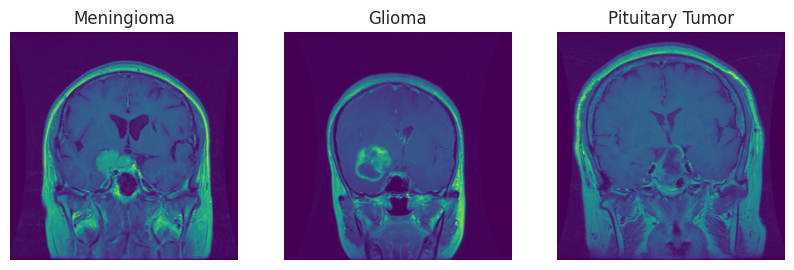

In [44]:
# Define paths to different tumor entities
meningiomas_path = "/kaggle/input/brain-tumor/1"
gliomas_path = "/kaggle/input/brain-tumor/2"
pituitary_tumors_path = "/kaggle/input/brain-tumor/3"

# Function to load images and labels for random image plotting
def load_random_image_and_label(folder_path, label):
    while True:
        filename = np.random.choice(os.listdir(folder_path))
        if filename.endswith(".png"):
            img = Image.open(os.path.join(folder_path, filename))
            img = img.convert('RGB')  
            return img, label

# Randomly plot one image from each tumor entity
plt.figure(figsize=(10, 5))
for i, (folder_path, label) in enumerate([(meningiomas_path, 'Meningioma'), (gliomas_path, 'Glioma'), (pituitary_tumors_path, 'Pituitary Tumor')]):
    img, _ = load_random_image_and_label(folder_path, i)
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
plt.show()

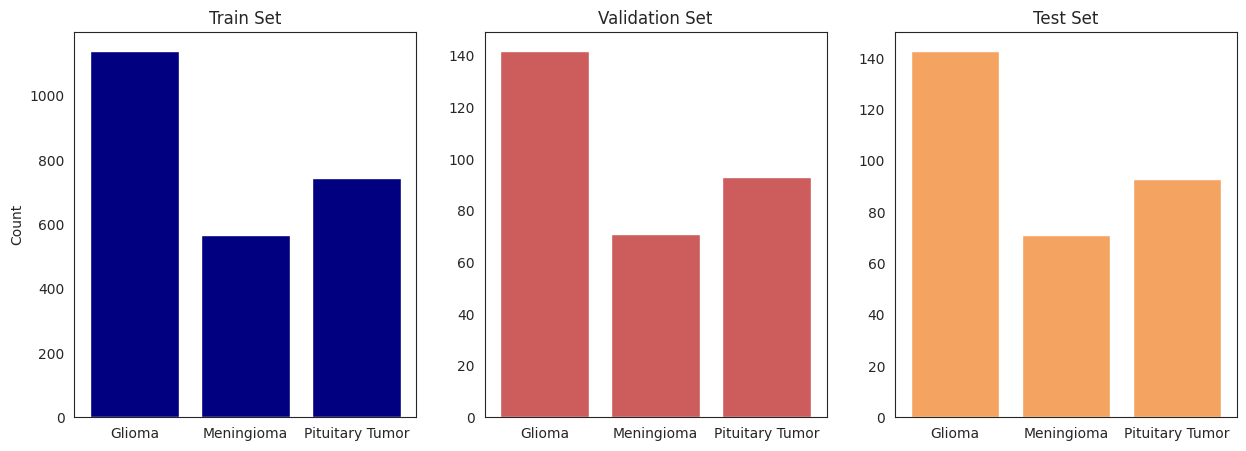

In [5]:
# Calculate counts of tumor entities in each dataset
train_counts = train_df['labels'].value_counts()
valid_counts = valid_df['labels'].value_counts()
test_counts = test_df['labels'].value_counts()

# Get unique labels and sort them
labels = train_df['labels'].unique()
labels = sorted(labels)

# Sort counts according to the sorted labels
train_counts = train_counts.reindex(labels)
valid_counts = valid_counts.reindex(labels)
test_counts = test_counts.reindex(labels)

# Plot the tumor entity distributions for each data set
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].bar(labels, train_counts, color='navy')
ax[0].set_title('Train Set')
ax[0].set_ylabel('Count')

ax[1].bar(labels, valid_counts, color='indianred')
ax[1].set_title('Validation Set')

ax[2].bar(labels, test_counts, color='sandybrown')
ax[2].set_title('Test Set')

plt.show()

In [6]:
# Print the absolute numbers of the counts 
print(train_counts, "\n")
print(valid_counts, "\n")
print(test_counts, "\n")

labels
Glioma             1141
Meningioma          566
Pituitary Tumor     744
Name: count, dtype: int64 

labels
Glioma             142
Meningioma          71
Pituitary Tumor     93
Name: count, dtype: int64 

labels
Glioma             143
Meningioma          71
Pituitary Tumor     93
Name: count, dtype: int64 



In [10]:
# Import pre-trained base ResNet50
resnet = ResNet50(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')

# Create the model
model = Sequential([
    resnet,
    BatchNormalization(),
    Dense(256, kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01), activation='relu'),
    Dropout(rate=0.5, seed=123),
    Dense(3, activation= 'softmax')
])

# Compile the model
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 24121219 (92.02 MB)
Trainable params: 24064003 (91.80 MB)
Non-trainable params: 57216 (223.50 KB)
________

In [11]:
# Use early stopping to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.0001,
    verbose=1,
    restore_best_weights=True,
)

In [12]:
# Train the model
history = model.fit(train_gen, epochs=30, callbacks=[early_stopping], validation_data=valid_gen)

Epoch 1/30
62/62 [==============================] - 82s 904ms/step - loss: 5.7178 - accuracy: 0.8425 - val_loss: 28.6370 - val_accuracy: 0.2516
Epoch 2/30
62/62 [==============================] - 35s 560ms/step - loss: 4.0959 - accuracy: 0.9661 - val_loss: 5.3586 - val_accuracy: 0.7320
Epoch 3/30
62/62 [==============================] - 36s 578ms/step - loss: 3.3682 - accuracy: 0.9865 - val_loss: 3.4950 - val_accuracy: 0.9379
Epoch 4/30
62/62 [==============================] - 35s 560ms/step - loss: 2.8626 - accuracy: 0.9951 - val_loss: 2.8024 - val_accuracy: 0.9608
Epoch 5/30
62/62 [==============================] - 37s 588ms/step - loss: 2.4799 - accuracy: 0.9980 - val_loss: 2.3530 - val_accuracy: 0.9706
Epoch 6/30
62/62 [==============================] - 35s 556ms/step - loss: 2.1447 - accuracy: 0.9980 - val_loss: 2.0448 - val_accuracy: 0.9641
Epoch 7/30
62/62 [==============================] - 35s 571ms/step - loss: 1.8621 - accuracy: 0.9988 - val_loss: 1.7731 - val_accuracy: 0.967

Best Validation Loss: 0.2486
Best Validation Accuracy: 0.9837


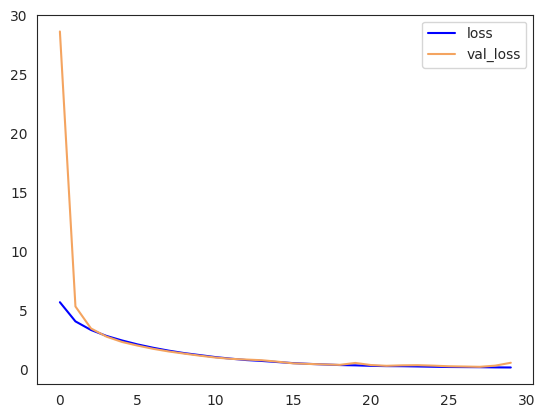

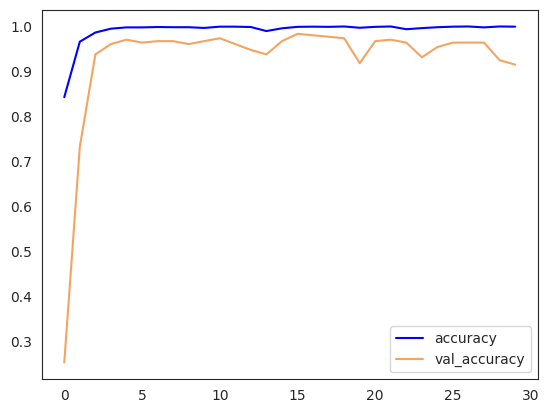

In [13]:
# Plot the validation loss and accuracy 
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(color=['blue', 'sandybrown'])
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(color=['blue', 'sandybrown'])

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_accuracy'].max()))

In [14]:
# Make predictions using the test data
predictions = model.predict(test_gen)

8/8 [==============================] - 8s 965ms/step


In [15]:
# Generate a classification report for the predicted test data 
test_predicted_labels = np.argmax(predictions, axis=1)
test_true_labels = test_gen.classes
class_names = list(test_gen.class_indices.keys())
test_accuracy = accuracy_score(test_true_labels, test_predicted_labels)

print(f"Test accuracy: {test_accuracy}\n")
print("Classification Report:")
print(classification_report(test_true_labels,test_predicted_labels, target_names=class_names))

Test accuracy: 0.9218241042345277

Classification Report:
                 precision    recall  f1-score   support

         Glioma       0.87      0.99      0.92       143
     Meningioma       0.96      0.77      0.86        71
Pituitary Tumor       1.00      0.94      0.97        93

       accuracy                           0.92       307
      macro avg       0.94      0.90      0.92       307
   weighted avg       0.93      0.92      0.92       307



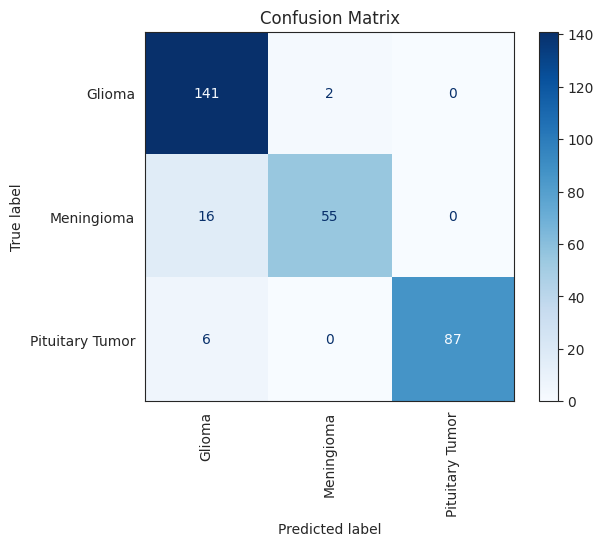

In [16]:
# Plot a confusion matrix for the test data predictions
conf_matrix = confusion_matrix(test_true_labels, test_predicted_labels)
conf_matrix_display = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
conf_matrix_display.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

In [17]:
# Save the whole CNN model
model.save('/kaggle/working/brain_tumor_classification_cnn_model.keras')

In [18]:
# Load the model as new_model to use it for new data
new_model = tf.keras.models.load_model('/kaggle/working/brain_tumor_classification_cnn_model.keras')

# Show the model architecture
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 24121219 (92.02 MB)
Trainable params: 24064003 (91.80 MB)
Non-trainable params: 57216 (223.50 KB)
________